# DEF CON 27 AI Village
## Fighting Malware with Deep Learning
## Convolutional Neural Networks and Static Analysis Data (Raw PE As Image)
### Angelo Oliveira @ang3loliveira
#### Dataset available at:
https://www.kaggle.com/ang3loliveira/malware-analysis-datasets-raw-pe-as-image

In [1]:
import numpy as np
np.random.seed(137)

import time
from collections import Counter
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [32]:
# Each goodware/malware was treated as an image: Scaled to 32x32x1 (grayscale) using Nearest Neighbor Interpolation
df = pd.read_csv('raw_pe_images.csv')
df.head()

,hash,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,b324140e1fb35dc6b694879ba1f2be45,15,15,239,15,223,36,102,243,102,...,31,242,245,169,212,17,255,160,122,1
1,1d32b1326a524b163eb74af645cd34d5,234,196,8,20,182,56,27,223,144,...,189,228,156,54,189,82,177,125,193,1
2,e44fea4913fc9fd91b8b07c4670aeac4,196,255,5,97,35,112,219,189,217,...,254,189,227,255,192,231,253,196,233,1
3,95badb16d862ba94ae85c44e4b31d749,232,252,183,39,51,1,255,87,94,...,210,52,55,95,230,48,53,103,65,1
4,f30f32a4f42678ef49a543356d580232,81,84,204,228,255,157,76,254,128,...,24,69,64,53,52,216,200,55,58,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51959 entries, 0 to 51958
Columns: 1026 entries, hash to malware
dtypes: int64(1025), object(1)
memory usage: 406.7+ MB


In [4]:
df.drop(['hash'], axis = 1, inplace = True)
df.head()

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_1015,pix_1016,pix_1017,pix_1018,pix_1019,pix_1020,pix_1021,pix_1022,pix_1023,malware
0,15,15,239,15,223,36,102,243,102,102,...,31,242,245,169,212,17,255,160,122,1
1,234,196,8,20,182,56,27,223,144,255,...,189,228,156,54,189,82,177,125,193,1
2,196,255,5,97,35,112,219,189,217,66,...,254,189,227,255,192,231,253,196,233,1
3,232,252,183,39,51,1,255,87,94,128,...,210,52,55,95,230,48,53,103,65,1
4,81,84,204,228,255,157,76,254,128,39,...,24,69,64,53,52,216,200,55,58,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51959 entries, 0 to 51958
Columns: 1025 entries, pix_0 to malware
dtypes: int64(1025)
memory usage: 406.3 MB


In [6]:
X = df.values[:, 0:1024].astype('float')
y = df.values[:, 1024].astype('int')
print(X.shape)
print(y.shape)

(51959, 1024)
(51959,)


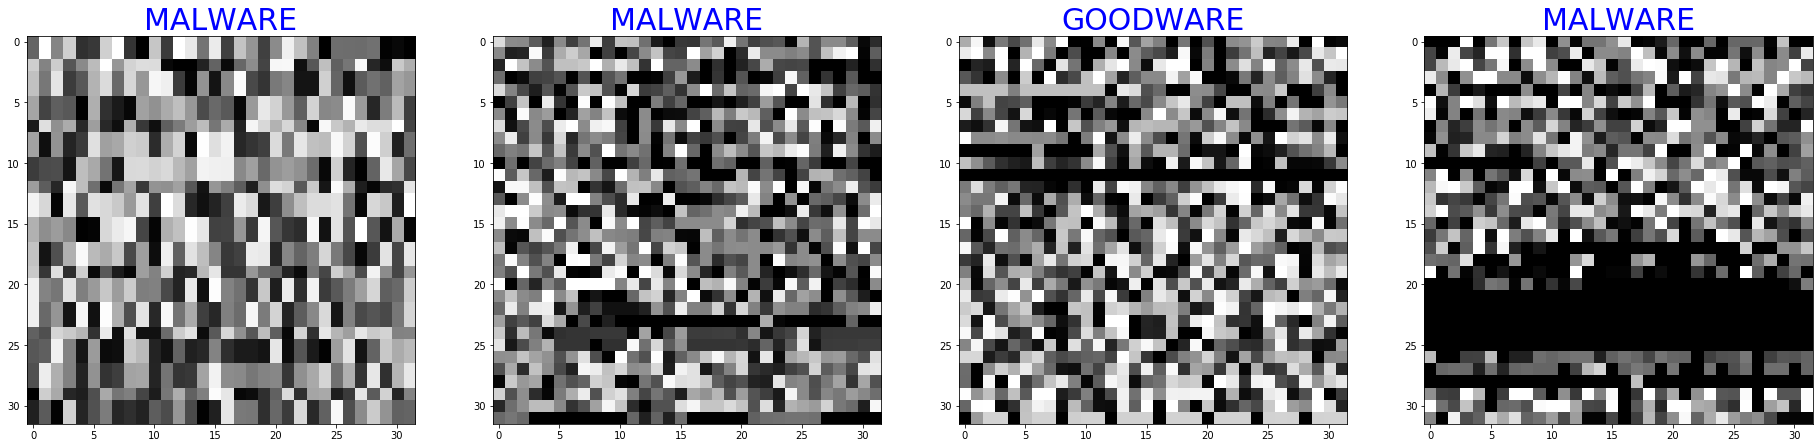

In [12]:
plt.figure(figsize = (32, 32))

examples = np.random.randint(0, X.shape[0], 4)

labels = []

for i in examples:
    if y[i] == 0:
        labels.append('GOODWARE')
    else:
        labels.append('MALWARE')

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.setp(plt.title(labels[i]), color = 'b', fontsize = 30)
    plt.imshow(
        X[np.random.randint(0, X.shape[0])].reshape(32, 32),
        cmap = 'gray',
        vmin = 0,
        vmax = 255)

In [13]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [14]:
check_imbalance(y)

[(0, 2583), (1, 49376)]
19.115756871854433


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

del X
del y

In [16]:
check_imbalance(y_train)
check_imbalance(y_test)

[(0, 1744), (1, 34627)]
19.85493119266055
[(0, 839), (1, 14749)]
17.579261025029798


In [17]:
scaler = MinMaxScaler()
X_train_std = scaler.fit_transform(X_train)

In [18]:
pd.DataFrame(X_train_std).head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.003922,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.501961,...,0.450980,0.349020,0.172549,0.047059,0.992157,0.662745,0.047059,0.890196,0.133333,0.156863
1,0.000000,0.141176,0.000000,0.419608,0.545098,0.000000,0.270588,0.545098,0.000000,0.352941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.094118,0.996078,0.062745,0.776471,0.313725,0.372549,0.407843,0.325490,0.223529,1.000000,...,0.047059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.627451,0.000000,0.545098,0.301961,0.972549,0.682353,0.062745,0.043137,0.000000,0.941176,...,0.321569,0.584314,0.043137,0.945098,0.839216,1.000000,0.250980,0.588235,0.317647,1.000000
4,0.000000,0.941176,0.607843,0.349020,0.270588,0.545098,1.000000,0.333333,0.270588,0.282353,...,1.000000,0.282353,1.000000,0.247059,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000


In [19]:
# SMOTE doesn't deal with categorical features
# SMOTE-NC (Nominal and Continuous) taking too much time

oversampler = RandomOverSampler()

X_res, y_res = oversampler.fit_resample(X_train_std, y_train)

check_imbalance(y_res)

del X_train_std

[(0, 34627), (1, 34627)]
1.0


## Visualization

In [20]:
def visualize(X, y, points, n_features):
    points = np.arange(points)
    np.random.shuffle(points)
    color = ['red' if l == 1 else 'green' for l in y[points]]
    for i in range(n_features):
        for j in range(n_features):
            if j > i:
                plt.scatter(X[points, i], X[points, j], color = color)
                plt.pause(0.1)
    return

In [21]:
def tsne(X):
    return TSNE().fit_transform(X)

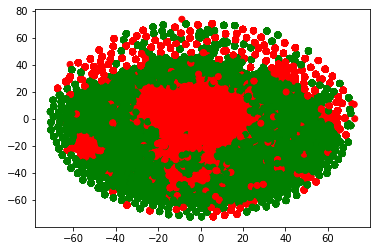

In [31]:
visualize(tsne(X_res), y_res, X_res.shape[0], 2)

del X_res
del y_res

## Enter Deep Learning

In [22]:
def select_model(model, model_arch):
    if model_arch == 1:
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(BatchNormalization())
    elif model_arch == 2:
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
    return

def create_model(model_arch = 1, neurons = 128, dropout_rate = 0.1, batch_drop = False):
    model = Sequential()
    model.add(Conv2D(32,
                     kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = (32, 32, 1),
                     padding = 'same'))
    select_model(model, model_arch)
    model.add(Conv2D(64,
                     kernel_size = (3, 3),
                     activation = 'relu',
                     padding = 'same'))
    select_model(model, model_arch)
    model.add(Flatten())
    model.add(Dense(neurons, activation = 'relu'))
    if batch_drop:
        model.add(BatchNormalization())
        model.add(Dropout(rate = dropout_rate))
    else:
        model.add(Dropout(rate = dropout_rate))
        model.add(BatchNormalization())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2

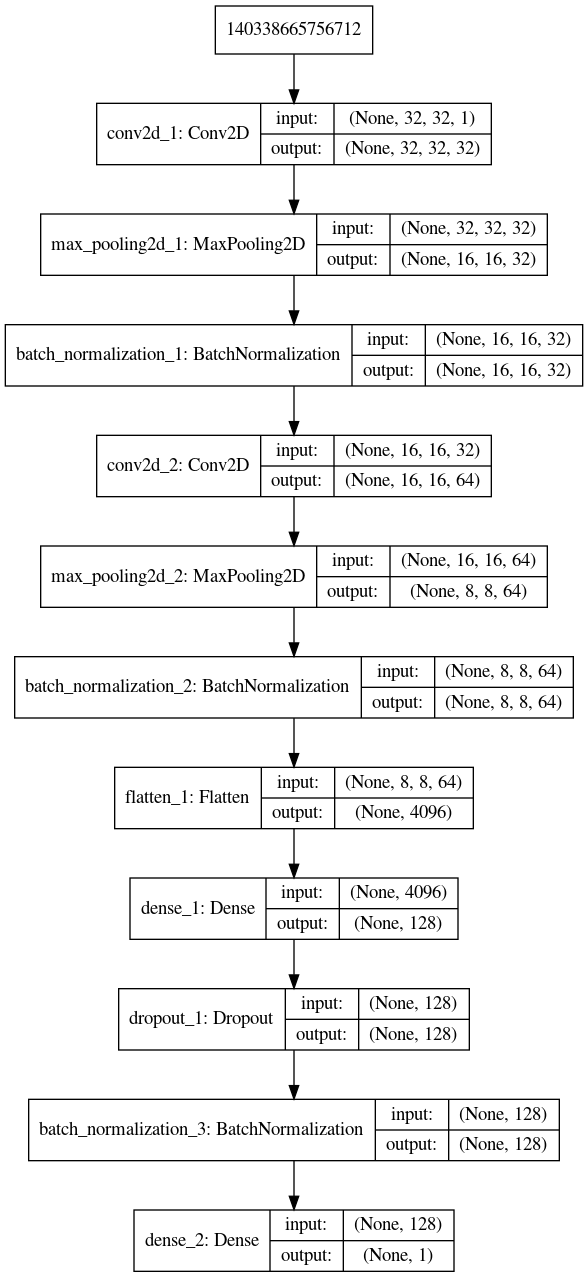

In [23]:
model = create_model()
model.summary()

plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)
del model
Image("model_plot.png")

## Model Selection

In [24]:
# Wrapper for Keras model to be used by the Pipeline
keras_classifier = KerasClassifier(
    build_fn = create_model,
    model_arch = 1,
    neurons = 128,
    dropout_rate = 0.1,
    batch_drop = False,
    batch_size = 64,
    epochs = 20,    
    verbose = 1
)

# Reshaping for CNN
def reshape_cnn(X):
    return X.reshape(-1, 32, 32, 1)

# Imbalanced Learn Pipeline
pipeline = Pipeline([
    ('sc', MinMaxScaler()),
    ('ros', RandomOverSampler()),
    ('rs', FunctionTransformer(reshape_cnn, validate = False)),
    ('kc', keras_classifier)
])

# Hyperparameters
model_arch = [1, 2]
neurons = [128, 256, 512]
dropout_rate = [0.1, 0.4, 0.6]
batch_drop = [False, True]

# Grid search using 3-fold cross-validation and score function Balanced Accuracy
# Balanced Accuracy = (TPR + TNR) / 2 = AUC (Binary Classification)
param_grid = dict(
    kc__model_arch = model_arch,
    kc__neurons = neurons,
    kc__dropout_rate = dropout_rate,
    kc__batch_drop = batch_drop
)

grid = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    scoring = 'balanced_accuracy',
    n_jobs = 1
)

In [25]:
t0 = time.time()
grid.fit(X_train, y_train)
print('Training / CV time: %is' % (time.time() - t0))

/home/angelo/anaconda3/envs/deeplearning_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
46126/46126 [==============================] - 5s 119us/step - loss: 0.1504 - acc: 0.9430
Epoch 2/20
46126/46126 [==============================] - 3s 61us/step - loss: 0.0131 - acc: 0.9975
Epoch 3/20
46126/46126 [==============================] - 3s 63us/step - loss: 0.0180 - acc: 0.9951
Epoch 4/20
46126/46126 [==============================] - 3s 63us/step - loss: 0.0211 - acc: 0.9935
Epoch 5/20
46126/46126 [==============================] - 3s 60us/step - loss: 0.0075 - acc: 0.9982
Epoch 6/20
46126/46126 [==============================] - 3s 59us/step - loss: 0.0148 - acc: 0.9954
Epoch 7/20
46126/46126 [==============================] - 3s 60us/step - loss: 0.0102 - acc: 0.9971
Epoch 8/20
46126/46126 [==============================] - 3s 59us/step - loss: 0.0035 - acc: 0.9994
Epoch 9/20
46126/46126 [==============================] - 3s 60us/step - loss: 0.0028 - acc: 0.9995
Epoch 10/20
46126/46126 [==========================

46220/46220 [==============================] - 3s 73us/step - loss: 0.0161 - acc: 0.9950
Epoch 17/20
46220/46220 [==============================] - 3s 73us/step - loss: 0.0041 - acc: 0.9989
Epoch 18/20
46220/46220 [==============================] - 3s 73us/step - loss: 0.0027 - acc: 0.9995
Epoch 19/20
46220/46220 [==============================] - 3s 75us/step - loss: 0.0032 - acc: 0.9992
Epoch 20/20
12124/12124 [==============================] - 1s 50us/step
Epoch 1/20
46162/46162 [==============================] - 5s 106us/step - loss: 0.1455 - acc: 0.9480
Epoch 2/20
46162/46162 [==============================] - 4s 77us/step - loss: 0.0189 - acc: 0.9954
Epoch 3/20
46162/46162 [==============================] - 4s 77us/step - loss: 0.0146 - acc: 0.9970
Epoch 4/20
46162/46162 [==============================] - 4s 83us/step - loss: 0.0189 - acc: 0.9943
Epoch 5/20
46162/46162 [==============================] - 4s 84us/step - loss: 0.0059 - acc: 0.9987
Epoch 6/20
46162/46162 [===========

46126/46126 [==============================] - 4s 80us/step - loss: 0.0018 - acc: 0.9997
Epoch 15/20
46126/46126 [==============================] - 4s 87us/step - loss: 0.0240 - acc: 0.9927
Epoch 16/20
46126/46126 [==============================] - 4s 85us/step - loss: 0.0027 - acc: 0.9994
Epoch 17/20
46126/46126 [==============================] - 4s 84us/step - loss: 0.0034 - acc: 0.9992
Epoch 18/20
46126/46126 [==============================] - 4s 82us/step - loss: 0.0030 - acc: 0.9994
Epoch 19/20
46126/46126 [==============================] - 4s 82us/step - loss: 0.0054 - acc: 0.9987
Epoch 20/20
12124/12124 [==============================] - 1s 89us/step
Epoch 1/20
46220/46220 [==============================] - 6s 131us/step - loss: 0.1922 - acc: 0.9267
Epoch 2/20
46220/46220 [==============================] - 4s 84us/step - loss: 0.0345 - acc: 0.9896
Epoch 3/20
46220/46220 [==============================] - 4s 84us/step - loss: 0.0171 - acc: 0.9951
Epoch 4/20
46220/46220 [=========

46162/46162 [==============================] - 4s 83us/step - loss: 0.0133 - acc: 0.9958
Epoch 13/20
46162/46162 [==============================] - 4s 85us/step - loss: 0.0269 - acc: 0.9910
Epoch 14/20
46162/46162 [==============================] - 4s 84us/step - loss: 0.0112 - acc: 0.9964
Epoch 15/20
46162/46162 [==============================] - 4s 85us/step - loss: 0.0060 - acc: 0.9982
Epoch 16/20
46162/46162 [==============================] - 4s 84us/step - loss: 0.0054 - acc: 0.9985
Epoch 17/20
46162/46162 [==============================] - 4s 84us/step - loss: 0.0059 - acc: 0.9982
Epoch 18/20
46162/46162 [==============================] - 4s 83us/step - loss: 0.0164 - acc: 0.9947
Epoch 19/20
46162/46162 [==============================] - 4s 84us/step - loss: 0.0093 - acc: 0.9970
Epoch 20/20
12123/12123 [==============================] - 2s 128us/step
Epoch 1/20
46126/46126 [==============================] - 7s 157us/step - loss: 0.1748 - acc: 0.9338
Epoch 2/20
46126/46126 [======

46220/46220 [==============================] - 5s 98us/step - loss: 0.0115 - acc: 0.9964
Epoch 11/20
46220/46220 [==============================] - 5s 99us/step - loss: 0.0126 - acc: 0.9958
Epoch 12/20
46220/46220 [==============================] - 5s 99us/step - loss: 0.0119 - acc: 0.9963
Epoch 13/20
46220/46220 [==============================] - 5s 98us/step - loss: 0.0133 - acc: 0.9957
Epoch 14/20
46220/46220 [==============================] - 5s 99us/step - loss: 0.0127 - acc: 0.9954
Epoch 15/20
46220/46220 [==============================] - 5s 98us/step - loss: 0.0063 - acc: 0.9982
Epoch 16/20
46220/46220 [==============================] - 5s 99us/step - loss: 0.0064 - acc: 0.9981
Epoch 17/20
46220/46220 [==============================] - 5s 98us/step - loss: 0.0064 - acc: 0.9981
Epoch 18/20
46220/46220 [==============================] - 5s 98us/step - loss: 0.0121 - acc: 0.9962
Epoch 19/20
46220/46220 [==============================] - 5s 98us/step - loss: 0.0072 - acc: 0.9980
Ep

46126/46126 [==============================] - 5s 112us/step - loss: 0.0249 - acc: 0.9919
Epoch 7/20
46126/46126 [==============================] - 5s 112us/step - loss: 0.0188 - acc: 0.9938
Epoch 8/20
46126/46126 [==============================] - 5s 113us/step - loss: 0.0157 - acc: 0.9953
Epoch 9/20
46126/46126 [==============================] - 5s 113us/step - loss: 0.0171 - acc: 0.9946
Epoch 10/20
46126/46126 [==============================] - 5s 113us/step - loss: 0.0223 - acc: 0.9920
Epoch 11/20
46126/46126 [==============================] - 5s 113us/step - loss: 0.0138 - acc: 0.9954
Epoch 12/20
46126/46126 [==============================] - 5s 112us/step - loss: 0.0096 - acc: 0.9972
Epoch 13/20
46126/46126 [==============================] - 5s 112us/step - loss: 0.0264 - acc: 0.9912
Epoch 14/20
46126/46126 [==============================] - 5s 112us/step - loss: 0.0124 - acc: 0.9960
Epoch 15/20
46126/46126 [==============================] - 5s 112us/step - loss: 0.0085 - acc: 0.

46162/46162 [==============================] - 6s 126us/step - loss: 0.1271 - acc: 0.9559
Epoch 3/20
46162/46162 [==============================] - 6s 126us/step - loss: 0.0587 - acc: 0.9811
Epoch 4/20
46162/46162 [==============================] - 6s 125us/step - loss: 0.0440 - acc: 0.9855
Epoch 5/20
46162/46162 [==============================] - 6s 126us/step - loss: 0.0357 - acc: 0.9883
Epoch 6/20
46162/46162 [==============================] - 6s 126us/step - loss: 0.0207 - acc: 0.9933
Epoch 7/20
46162/46162 [==============================] - 6s 125us/step - loss: 0.0279 - acc: 0.9908
Epoch 8/20
46162/46162 [==============================] - 6s 125us/step - loss: 0.0267 - acc: 0.9908
Epoch 9/20
46162/46162 [==============================] - 6s 126us/step - loss: 0.0156 - acc: 0.9952
Epoch 10/20
46162/46162 [==============================] - 6s 125us/step - loss: 0.0160 - acc: 0.9945
Epoch 11/20
46162/46162 [==============================] - 6s 125us/step - loss: 0.0121 - acc: 0.9961

46126/46126 [==============================] - 6s 136us/step - loss: 0.0057 - acc: 0.9982
Epoch 19/20
46126/46126 [==============================] - 6s 136us/step - loss: 0.0052 - acc: 0.9983
Epoch 20/20
12124/12124 [==============================] - 4s 326us/step
Epoch 1/20
46220/46220 [==============================] - 14s 305us/step - loss: 0.1449 - acc: 0.9473
Epoch 2/20
46220/46220 [==============================] - 6s 139us/step - loss: 0.0148 - acc: 0.9972
Epoch 3/20
46220/46220 [==============================] - 6s 140us/step - loss: 0.0161 - acc: 0.9954
Epoch 4/20
46220/46220 [==============================] - 6s 139us/step - loss: 0.0130 - acc: 0.9962
Epoch 5/20
46220/46220 [==============================] - 6s 139us/step - loss: 0.0079 - acc: 0.9981
Epoch 6/20
46220/46220 [==============================] - 6s 138us/step - loss: 0.0177 - acc: 0.9944
Epoch 7/20
46220/46220 [==============================] - 6s 139us/step - loss: 0.0045 - acc: 0.9990
Epoch 8/20
46220/46220 [===

46162/46162 [==============================] - 7s 153us/step - loss: 0.0030 - acc: 0.9994
Epoch 15/20
46162/46162 [==============================] - 7s 153us/step - loss: 0.0113 - acc: 0.9965
Epoch 16/20
46162/46162 [==============================] - 7s 153us/step - loss: 0.0044 - acc: 0.9989
Epoch 17/20
46162/46162 [==============================] - 7s 153us/step - loss: 0.0020 - acc: 0.9997
Epoch 18/20
46162/46162 [==============================] - 7s 153us/step - loss: 0.0018 - acc: 0.9997
Epoch 19/20
46162/46162 [==============================] - 7s 153us/step - loss: 0.0076 - acc: 0.9981
Epoch 20/20
12123/12123 [==============================] - 5s 383us/step
Epoch 1/20
46126/46126 [==============================] - 16s 345us/step - loss: 0.2065 - acc: 0.9208
Epoch 2/20
46126/46126 [==============================] - 7s 151us/step - loss: 0.0423 - acc: 0.9874
Epoch 3/20
46126/46126 [==============================] - 7s 151us/step - loss: 0.0213 - acc: 0.9940
Epoch 4/20
46126/46126 

46220/46220 [==============================] - 8s 167us/step - loss: 0.0030 - acc: 0.9993
Epoch 11/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0084 - acc: 0.9973
Epoch 12/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0098 - acc: 0.9968
Epoch 13/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0061 - acc: 0.9979
Epoch 14/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0028 - acc: 0.9993
Epoch 15/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0032 - acc: 0.9991
Epoch 16/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0088 - acc: 0.9972
Epoch 17/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0066 - acc: 0.9982
Epoch 18/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0030 - acc: 0.9993
Epoch 19/20
46220/46220 [==============================] - 8s 167us/step - loss: 0.0072 - acc:

46126/46126 [==============================] - 8s 175us/step - loss: 0.0122 - acc: 0.9967
Epoch 7/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0176 - acc: 0.9942
Epoch 8/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0156 - acc: 0.9952
Epoch 9/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0066 - acc: 0.9982
Epoch 10/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0075 - acc: 0.9978
Epoch 11/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0115 - acc: 0.9965
Epoch 12/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0120 - acc: 0.9964
Epoch 13/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0071 - acc: 0.9981
Epoch 14/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0053 - acc: 0.9987
Epoch 15/20
46126/46126 [==============================] - 8s 174us/step - loss: 0.0106 - acc: 0.

46162/46162 [==============================] - 8s 183us/step - loss: 0.0566 - acc: 0.9815
Epoch 3/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0269 - acc: 0.9911
Epoch 4/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0253 - acc: 0.9921
Epoch 5/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0205 - acc: 0.9937
Epoch 6/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0116 - acc: 0.9968
Epoch 7/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0167 - acc: 0.9944
Epoch 8/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0135 - acc: 0.9961
Epoch 9/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0159 - acc: 0.9953
Epoch 10/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0119 - acc: 0.9958
Epoch 11/20
46162/46162 [==============================] - 8s 183us/step - loss: 0.0099 - acc: 0.9971

46126/46126 [==============================] - 9s 191us/step - loss: 0.0081 - acc: 0.9976
Epoch 19/20
46126/46126 [==============================] - 9s 190us/step - loss: 0.0076 - acc: 0.9979
Epoch 20/20
12124/12124 [==============================] - 8s 672us/step
Epoch 1/20
46220/46220 [==============================] - 25s 532us/step - loss: 0.2114 - acc: 0.9189
Epoch 2/20
46220/46220 [==============================] - 9s 193us/step - loss: 0.0400 - acc: 0.9874
Epoch 3/20
46220/46220 [==============================] - 9s 192us/step - loss: 0.0274 - acc: 0.9910
Epoch 4/20
46220/46220 [==============================] - 9s 192us/step - loss: 0.0239 - acc: 0.9921
Epoch 5/20
46220/46220 [==============================] - 9s 192us/step - loss: 0.0231 - acc: 0.9922
Epoch 6/20
46220/46220 [==============================] - 9s 192us/step - loss: 0.0210 - acc: 0.9930
Epoch 7/20
46220/46220 [==============================] - 9s 192us/step - loss: 0.0135 - acc: 0.9957
Epoch 8/20
46220/46220 [===

46162/46162 [==============================] - 9s 203us/step - loss: 0.0109 - acc: 0.9967
Epoch 15/20
46162/46162 [==============================] - 9s 203us/step - loss: 0.0155 - acc: 0.9951
Epoch 16/20
46162/46162 [==============================] - 9s 202us/step - loss: 0.0085 - acc: 0.9974
Epoch 17/20
46162/46162 [==============================] - 9s 202us/step - loss: 0.0103 - acc: 0.9970
Epoch 18/20
46162/46162 [==============================] - 9s 203us/step - loss: 0.0063 - acc: 0.9982
Epoch 19/20
46162/46162 [==============================] - 9s 203us/step - loss: 0.0125 - acc: 0.9963
Epoch 20/20
12123/12123 [==============================] - 10s 790us/step
Epoch 1/20
46126/46126 [==============================] - 28s 603us/step - loss: 0.2752 - acc: 0.8910
Epoch 2/20
46126/46126 [==============================] - 10s 207us/step - loss: 0.0766 - acc: 0.9745
Epoch 3/20
46126/46126 [==============================] - 10s 207us/step - loss: 0.0419 - acc: 0.9863
Epoch 4/20
46126/461

In [26]:
def grid_results(model):
    print("Best: %.4f using %s" % (model.best_score_, model.best_params_))
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%.4f (%.4f) with: %r" % (mean, stdev, param))

In [27]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y, pred))
    print('Accuracy: %.4f' % (accuracy_score(y, pred)))    
    print('Precision: %.4f' % (precision_score(y, pred)))    
    print('Recall: %.4f' % (recall_score(y, pred)))
    print('F1-Score: %.4f' % (f1_score(y, pred)))    
    print('Balanced Accuracy (ROC AUC): %.4f' % (balanced_accuracy_score(y, pred)))
    return

In [28]:
# Fully connected layer: Dropout than Batchnorm
# Convolutional layers: Batchnorm than Maxpooling
grid_results(grid)

Best: 0.6316 using {'kc__batch_drop': False, 'kc__dropout_rate': 0.6, 'kc__model_arch': 2, 'kc__neurons': 128}
0.6014 (0.0129) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 128}
0.5912 (0.0142) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 256}
0.6057 (0.0224) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 1, 'kc__neurons': 512}
0.5993 (0.0136) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 128}
0.6141 (0.0039) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 256}
0.6114 (0.0072) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.1, 'kc__model_arch': 2, 'kc__neurons': 512}
0.6047 (0.0052) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__model_arch': 1, 'kc__neurons': 128}
0.5999 (0.0078) with: {'kc__batch_drop': False, 'kc__dropout_rate': 0.4, 'kc__model_arch': 

## Evaluation

In [29]:
# Benchmark
model_evaluate(y_test, np.ones(y_test.shape))

Confusion matrix
[TN FP]
[FN TP]
[[    0   839]
 [    0 14749]]
Accuracy: 0.9462
Precision: 0.9462
Recall: 1.0000
F1-Score: 0.9723
Balanced Accuracy (ROC AUC): 0.5000


In [30]:
# Why?
# We need more examples, since the model is overfitting
# There's a catch: Packers!
model_evaluate(y_test, grid.predict(X_test))

15588/15588 [==============================] - 11s 694us/step
Confusion matrix
[TN FP]
[FN TP]
[[  268   571]
 [  272 14477]]
Accuracy: 0.9459
Precision: 0.9621
Recall: 0.9816
F1-Score: 0.9717
Balanced Accuracy (ROC AUC): 0.6505
